# Modeling

In [126]:
import pandas as pd
from datetime import timedelta

In [2]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\flagship'

In [3]:
toy_dataset_df = pd.read_csv('toy_dataset_1_10_23.csv')
toy_products_df = pd.read_csv('toy_products_1_10_23.csv')

In [4]:
toy_products_df.shape

(3125, 6)

In [5]:
toy_dataset_df.shape

(32151, 23)

In [6]:
toy_dataset_df['timestamp'] = pd.to_datetime(toy_dataset_df['timestamp'])

#### Create train, test data sets based on date split

In [119]:
split_date = '2022-04-01' # choose a date to split the data - roughly 80/20 split
train = toy_dataset_df[toy_dataset_df['timestamp'] < split_date]
test = toy_dataset_df[toy_dataset_df['timestamp'] >= split_date]

In [120]:
# percent of data in training data set
round(train.shape[0] / toy_dataset_df.shape[0] * 100.0,2)

81.64

In [124]:
train.shape

(26248, 23)

In [121]:
test.shape

(5903, 23)

### Baseline Model - top 10 titles over previous week

In [106]:
def get_top10_model_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular product_titles sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby('product_title').size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['transaction_date'] = as_of_dt
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'prev_wk_cnt', 'transaction_date', 'title_rank']
    return top10_last_wk_df

In [107]:
get_top10_model_preds(as_of_dt='2022-08-13')

,title_pred,prev_wk_cnt,transaction_date,title_rank
6,Olympic Running,52,2022-08-13,1.0
3,Iron Running,26,2022-08-13,2.0
4,League Running,23,2022-08-13,3.0
0,Bejeweled Boot,17,2022-08-13,4.0
2,Hustler Boot,17,2022-08-13,5.0
5,Marathon Running,15,2022-08-13,6.0
8,Rogue Sneaker,12,2022-08-13,7.0
1,Classic Sneaker,9,2022-08-13,8.0
12,Vanguard Sandal,9,2022-08-13,9.0
10,Stacked Hiking Boot,8,2022-08-13,10.0


In [127]:
test_dates = test['timestamp'].dt.date.unique().tolist()

In [115]:
full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_model_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred','title_rank']], 
                       left_on='product_title',
                       right_on='title_pred',
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [116]:
full_eval_df.shape

(5903, 25)

In [118]:
full_eval_df.head()

,Unnamed: 0,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,product_size,...,zip_med_age,zip_male_female_ratio,zip_tot_pop,zip_tot_white_nh,zip_med_hh_income,zip_mean_hh_income,zip_pct_emp_lf,zip_unemp_rate,title_pred,title_rank
0,58,2022-05-22 14:00:00,701140827973030343,901098790880827689,71.0,Olympic Running,Han Purple,Kids,Running,12.5,...,47.2,87.2,30908.0,23172.0,163016.0,268666.0,65.9,2.3,Olympic Running,1.0
1,2955,2022-05-22 08:00:00,5009790446010554491,6458481418216291208,224.0,Olympic Running,Vermilion (Plochere),Men,Running,9.0,...,28.4,98.8,75068.0,21235.0,55269.0,71979.0,62.6,7.0,Olympic Running,1.0
2,4413,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Prussian Blue,Men,Running,14.5,...,38.4,91.0,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running,3.0
3,4414,2022-05-22 09:00:00,9583150991463340343,529781945332660367,275.0,Iron Running,Pastel Magenta,Women,Running,8.5,...,38.4,91.0,44041.0,33057.0,85768.0,111260.0,66.1,4.1,Iron Running,3.0
4,9795,2022-05-22 16:00:00,12894699444984033920,9918956172069791431,224.0,Olympic Running,Prussian Blue,Women,Running,9.0,...,49.4,90.5,12592.0,9817.0,197000.0,329223.0,59.8,4.4,Olympic Running,1.0


In [134]:
# Percent of test purchases that were in top 10
full_eval_df['title_rank'].count() / full_eval_df.shape[0]

0.9552769778078943

In [135]:
full_eval_df['title_rank'].mean()

3.7389608086540167

<AxesSubplot:>

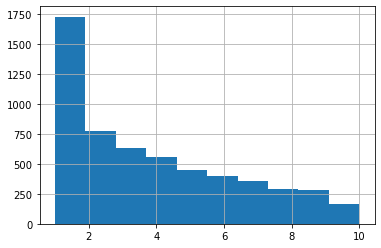

In [136]:
full_eval_df['title_rank'].hist()

In [ ]:
# Assuming the joined dataframe is named 'joined_df'
# and the predicted recommended items are stored in a column named 'predicted_items'
# and the actual purchased items are stored in a column named 'actual_items'

k = 10  # set the value of k for precision at k

# Define a function to calculate precision at k
def precision_at_k(row):
    predicted_items = row['predicted_items'][:k]  # get the top k predicted items
    actual_items = row['actual_items']
    if len(predicted_items) == 0:
        return 0  # if there are no predicted items, precision is 0
    else:
        # calculate precision as the number of correctly predicted items
        # divided by the total number of predicted items
        precision = len(set(predicted_items).intersection(actual_items)) / float(len(predicted_items))
        return precision

# Apply the precision_at_k function to each row in the joined_df and store the results in a new column
joined_df['precision_at_k'] = joined_df.apply(precision_at_k, axis=1)

# Calculate the mean precision at k for all rows in the joined_df
mean_precision_at_k = joined_df['precision_at_k'].mean()

print("Mean precision at k of", k, ":", mean_precision_at_k)